In [1]:
import pandas as pd
import os
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
import plotnine

warnings.filterwarnings('ignore')

### Junta tudo

In [2]:
def junta_tudo(folder, colunas=None):
    
    df = pd.DataFrame()
    caminho_pasta = os.path.join(folder, '*csv')
    files = glob.glob(caminho_pasta)
    for file in files:
        dfloop = pd.read_csv(file, sep=';', usecols=colunas)
        df = pd.concat([df,dfloop])
    return df

In [3]:
'''

df = junta_tudo('./csv_v2/')

df.to_csv('./csv_v2/infracoes_filt_new.csv', index=False, sep=';')
'''

'''
infracoes = open('infracoes.txt','r')

listaInfracoes = []

for l in infracoes:
    linha = l.strip()
    listaInfracoes.append(linha)

del infracoes

df = df[df.descricao_abreviada.isin(listaInfracoes)]

df.to_csv('./csv_v2/infracoes_filt.csv', index=False, sep=';')

'''

pass

### STL

Filtrando com as infracões selecionadas, houve redução de 63.219.086 para 47.066.206

In [4]:
df = pd.read_csv(
    'csv_v2/infracoes_filt_new.csv', 
    sep=';', 
    #nrows=15000000, 
    #engine='c',
    usecols=['dat_infracao', 'uf_infracao'],
)

df.dat_infracao = pd.to_datetime(df['dat_infracao'])

In [5]:
%%script false --no-raise-error

df = df.sort_values('dat_infracao', ascending=True)
df['dia'] = df.dat_infracao.dt.weekday
df['Semana do ano'] = df.dat_infracao.dt.week

df_dias = df.uf_infracao.groupby(by=[df.dia, df['Semana do ano']]).count().unstack()
df_dias.reset_index(inplace = True)

dias = {
    0 : 'Segunda',
    1 : 'Terça',
    2 : 'Quarta',
    3 : 'Quinta',
    4 : 'Sexta',
    5 : 'Sábado',
    6 : 'Domingo',
    'semana': 'Semana',
    'dia' : 'Dia'
}

for k, v in dias.items():
    df_dias.loc[df_dias.dia == k, 'dia'] = v

df_dias.set_index('dia', inplace= True)


sns.set(rc={'figure.figsize':(15,8)})
sns.set(font_scale = 1)
#sns.set_style('greygrid')
sns.set(rc={'axes.facecolor':'white', 'grid.color':'#ededed', 'figure.facecolor':'white'})

linha = 10

fig = sns.lineplot(df_dias.drop(columns=[53]),marker='o',legend='brief', linestyle='', dashes=False, alpha=0.9, markersize = linha, linewidth=linha)
fig.set(xlabel = '\n\nDias da semana', ylabel='Infrações\n', title='Infrações por dia da semana\npor semana do ano')

sns.lineplot(data=df_dias.drop(columns=[53]), dashes=False,  alpha=.2, legend=False, linewidth=linha, ax=fig)
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))
plt.show()


'''h,l = fig.get_legend_handles_labels()
l1 = fig.legend(h[:int(len(h)/2)],l[:int(len(l)/2)], loc='lower left')
l2 = fig.legend(h[int(len(h)/2):],l[int(len(l)/2):], loc='upper right')
fig.add_artist(l1) # we need this because the 2nd call to legend() erases the firs'''


## Anual

In [6]:
df_ = df.groupby(by=[df.dat_infracao]).count()

In [7]:
df_2 = df_.copy()

df_2.reset_index(inplace=True)
df_2['Semana'] = df_2.reset_index()['dat_infracao'].dt.week
df_2['Ano'] = df_2.reset_index()['dat_infracao'].dt.year
df_2['Dia_Semana']  = df_2.reset_index()['dat_infracao'].dt.weekday
df_2['Dia']  = df_2.reset_index()['dat_infracao'].dt.day

df_2.rename({'uf_infracao':'Infrações', 'Semana':'Semana'}, axis=1, inplace=True)


In [8]:
df_2.head()

,dat_infracao,Infrações,Semana,Ano,Dia_Semana,Dia
0,2007-01-01,3006,1,2007,0,1
1,2007-01-02,3828,1,2007,1,2
2,2007-01-03,2337,1,2007,2,3
3,2007-01-04,4153,1,2007,3,4
4,2007-01-05,2758,1,2007,4,5


[Text(0.5, 0, '\nSemanas do ano'), Text(0, 0.5, 'Infrações\n')]

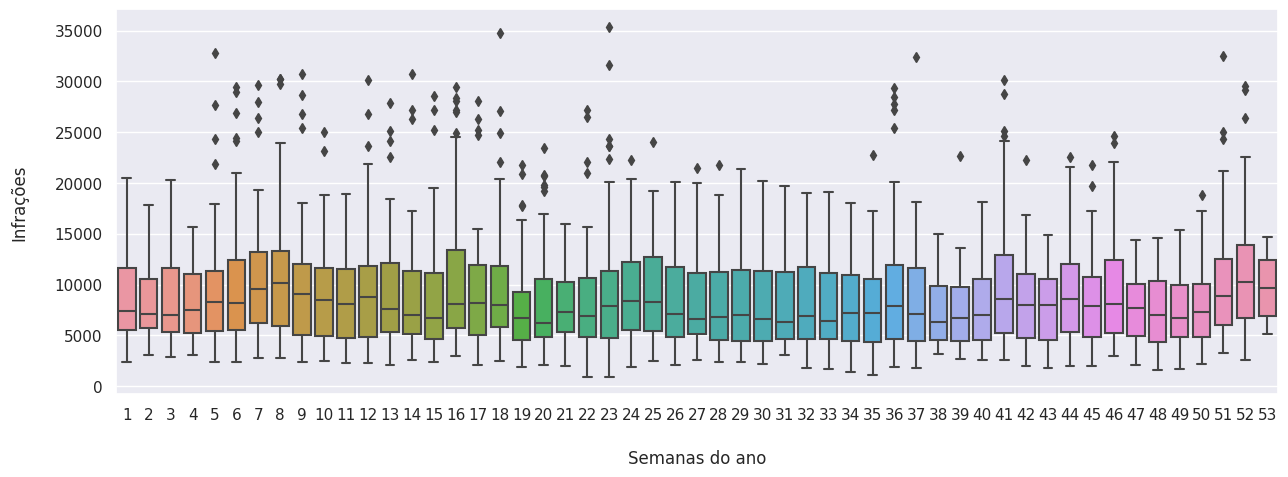

In [9]:
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(
    x= df_2.Semana,
    y= df_2['Infrações'],
    ).set(xlabel='\nSemanas do ano', ylabel='Infrações\n')

[Text(0.5, 0, '\nDias do mês'), Text(0, 0.5, 'Infrações\n')]

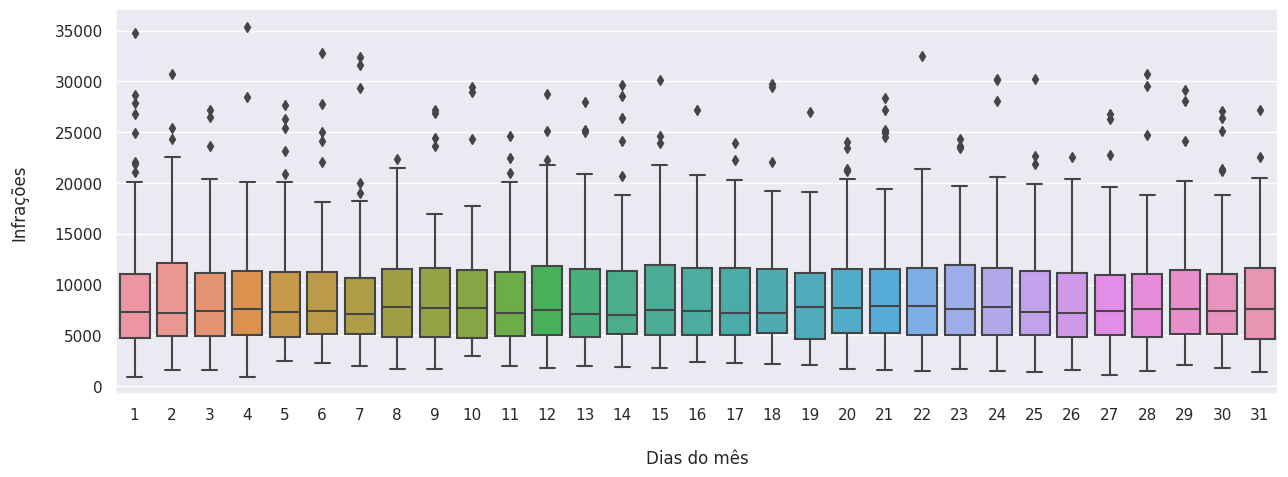

In [10]:
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(
    x= df_2.Dia,
    y= df_2['Infrações']
    ).set(xlabel='\nDias do mês', ylabel='Infrações\n')

[Text(0.5, 0, 'Anos'), Text(0, 0.5, 'Infrações\n')]

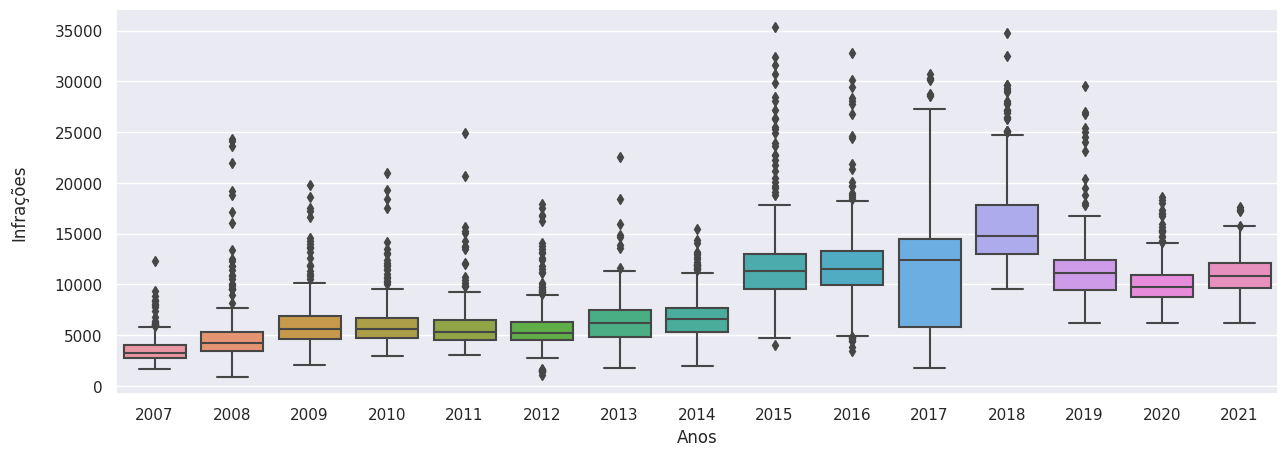

In [11]:
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(
    x= df_2.Ano,
    y= df_2['Infrações']
    ).set(xlabel='Anos', ylabel='Infrações\n')

In [12]:
%%script false --no-raise-error

sns.set(rc={'figure.figsize':(160,90)})
sns.set(font_scale = 1)
#sns.set_style('greygrid')
sns.set(rc={'axes.facecolor':'black', 'grid.color':'black', 'figure.facecolor':'black'})

linha = 10

fig = sns.lineplot(x=df_2.Ano, y=df_2.Infrações, hue= df_2.Dia, marker='o',legend=False, linestyle='', dashes=False, alpha=0, markersize = linha, linewidth=linha)
sns.lineplot(x=df_2.Ano, y=df_2.Infrações, hue= df_2.Dia, dashes=False,  alpha=.2, legend=False, linewidth=linha, ax=fig)
#sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))
plt.show()


[Text(0.5, 0, 'Anos')]

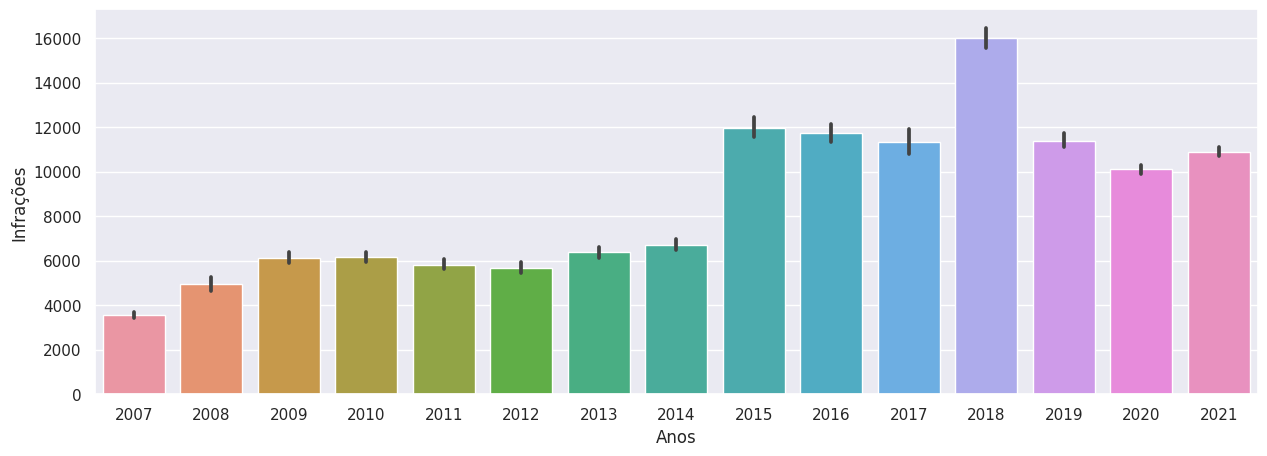

In [13]:
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(
    x= df_2.dat_infracao.dt.year,
    y= df_2['Infrações']
    ).set(xlabel='Anos')

In [14]:
df_['ocorrencias'] = np.log(df_.uf_infracao)
df_.drop(['uf_infracao'], axis=1, inplace = True)

df_.head()

,ocorrencias
dat_infracao,
2007-01-01,8.008366
2007-01-02,8.250098
2007-01-03,7.756623
2007-01-04,8.331586
2007-01-05,7.922261


In [15]:
mstl = MSTL(
    df_,
    periods=[7, 52, 365],
    windows=[101, 101, 101],
    iterate=3,
    stl_kwargs={
        'trend':1001,
        'seasonal_deg':0
    }
)
res = mstl.fit()

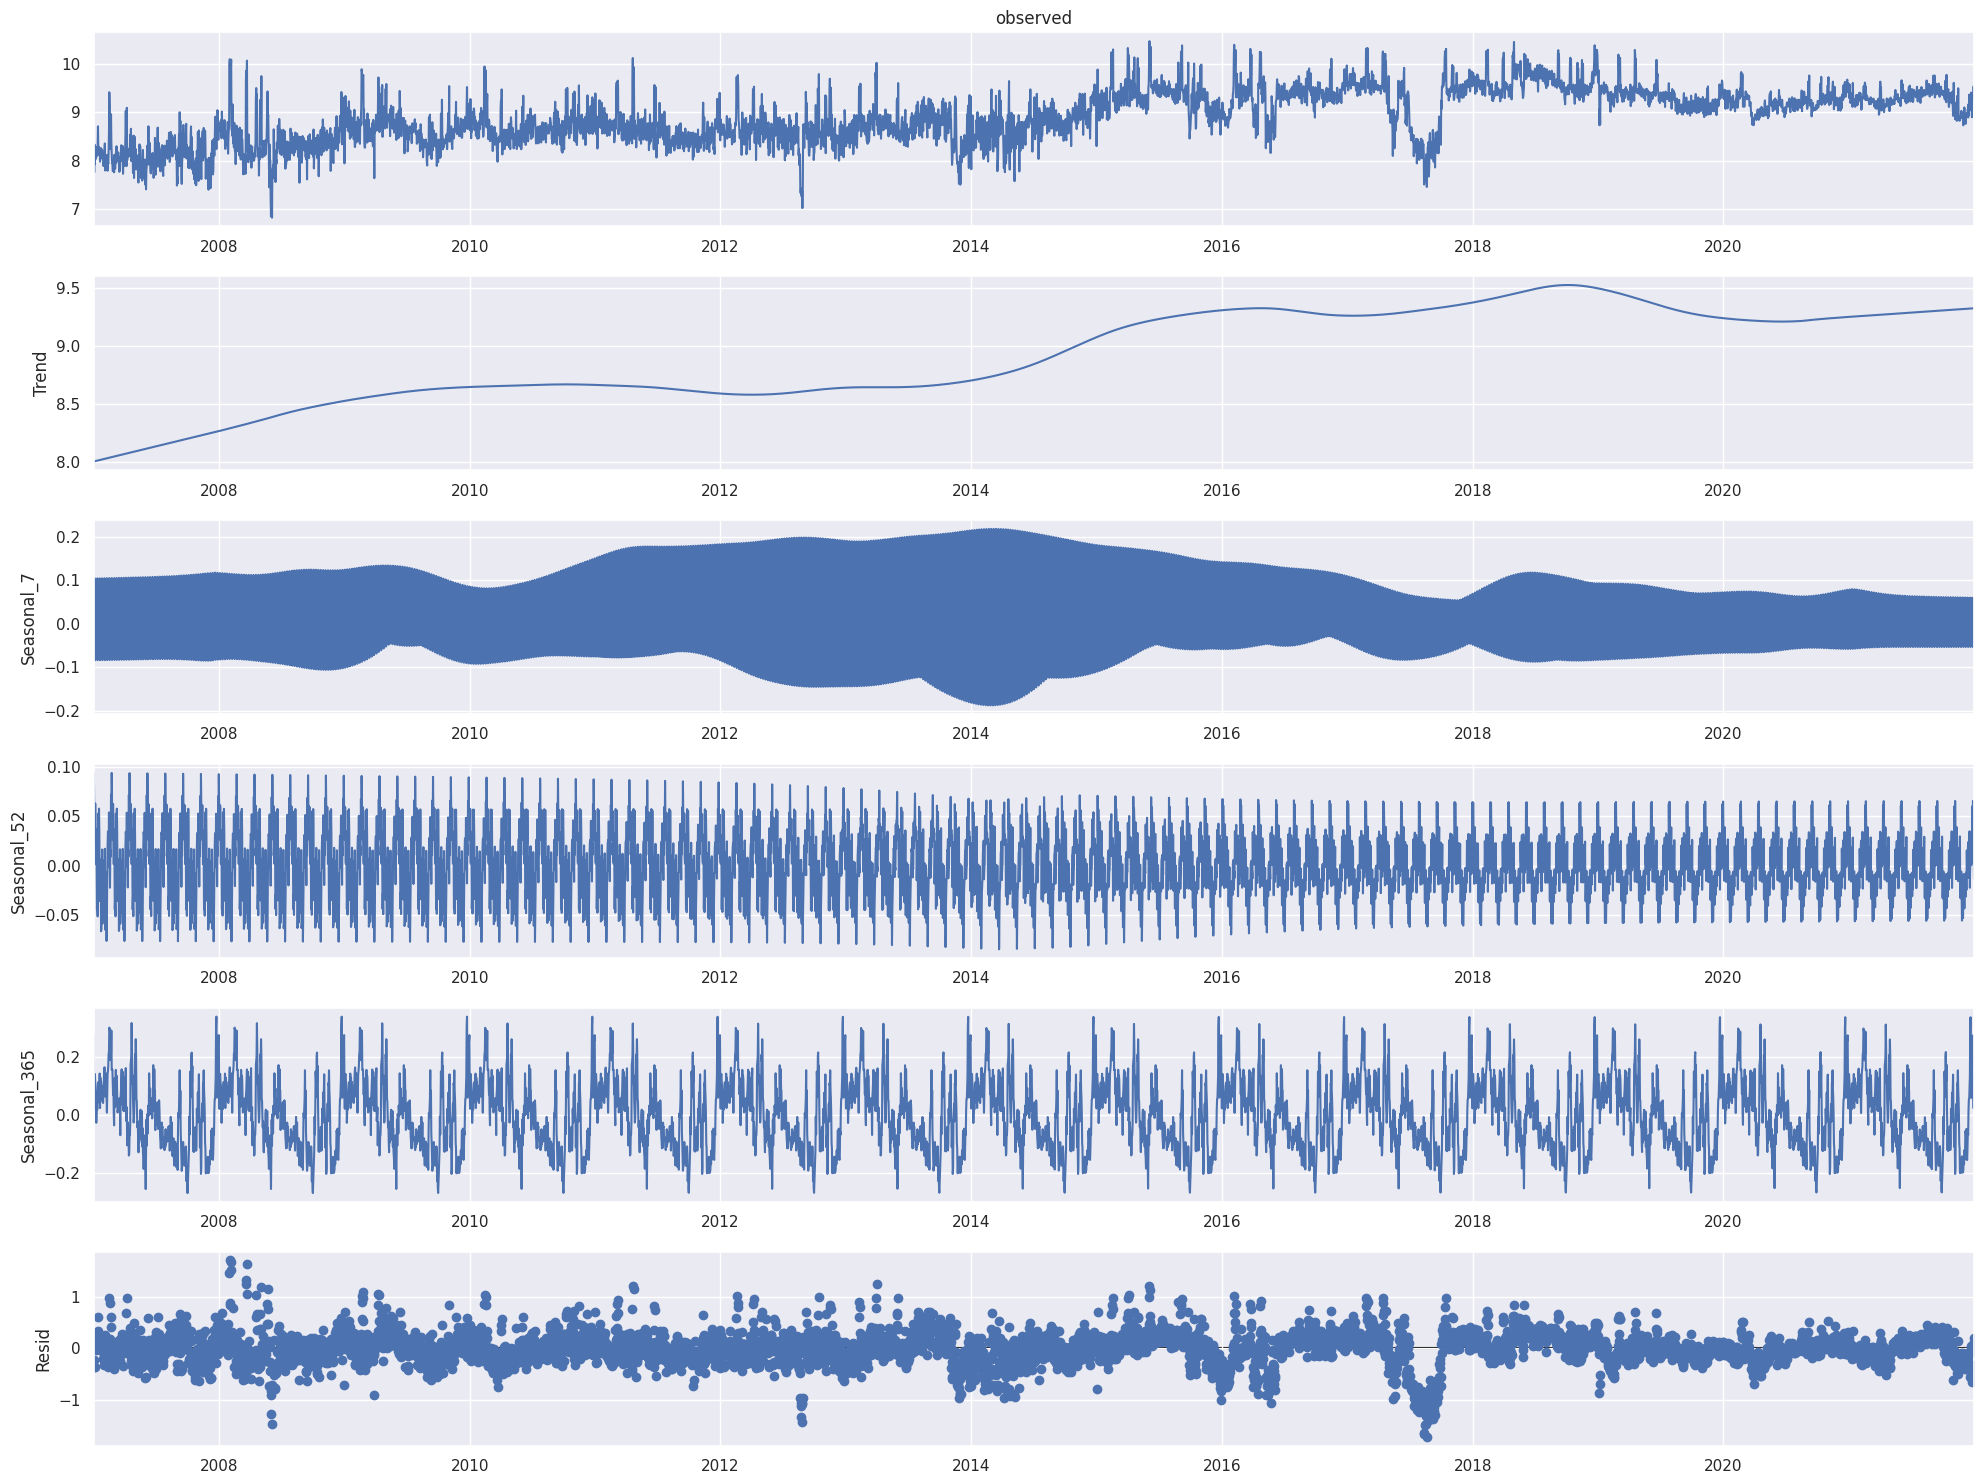

In [16]:
#df_2 = df_.loc['2007-01-01':'2007-12-31']
sns.set(rc={'figure.figsize':(20,15)})
fig = res.plot(observed=True)


In [17]:
result_list = [res.observed, res.trend, res.resid, res.seasonal]
results = pd.concat(result_list, axis=1)

rename = {
    'observed':'Original',
    'trend':'Tendência',
    'seasonal_7':'Intra-semanal',
    'seasonal_52': 'Semanal',
    'seasonal_365': 'Anual',
    'resid':'Resíduo'
    }

results.rename(rename, axis=1, inplace=True)
results.reset_index(inplace=True)


data = results['dat_infracao']
observado = results['Original']
tendencia = results['Tendência']
residuo = results['Resíduo']
diario = results['Intra-semanal']
semanal = results['Semanal']
anual = results['Anual']


<AxesSubplot: xlabel='Resíduo', ylabel='Count'>

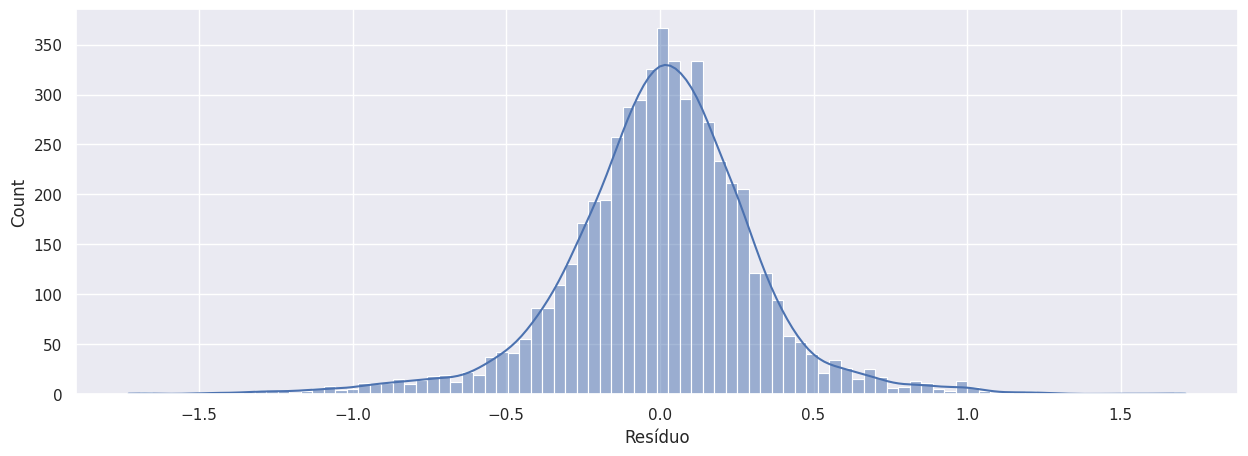

In [18]:
sns.set(rc={'figure.figsize':(15,5)})
sns.histplot(residuo, kde=True)

<AxesSubplot: xlabel='Resíduo', ylabel='Count'>

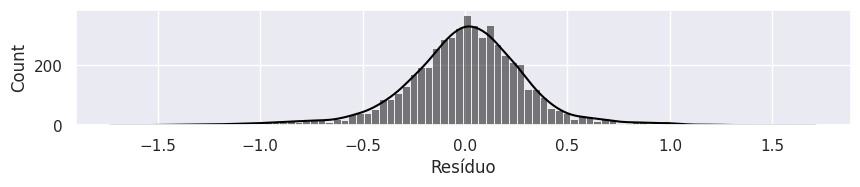

In [19]:
sns.set(rc={'figure.figsize':(10,1.5)})

plots = [observado, tendencia, residuo, diario, semanal, anual]

sns.histplot(residuo, kde=True, alpha=0.5, color='black')

[Text(0.5, 0, '')]

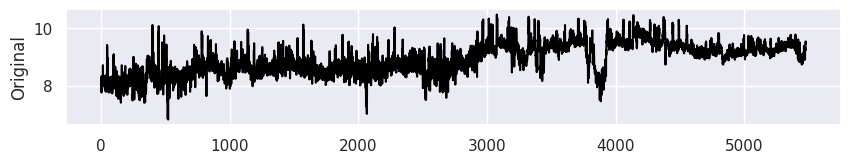

In [20]:
sns.lineplot(observado, alpha=1, color = 'black').set(xlabel=None)

[Text(0.5, 0, '')]

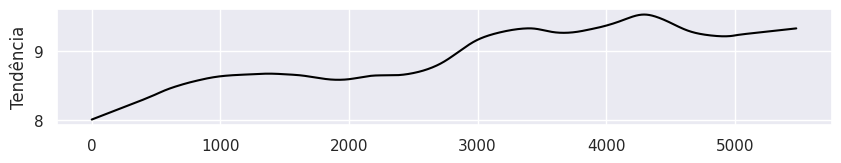

In [21]:
sns.lineplot(tendencia, alpha=1, color = 'black').set(xlabel=None)

[Text(0.5, 0, '')]

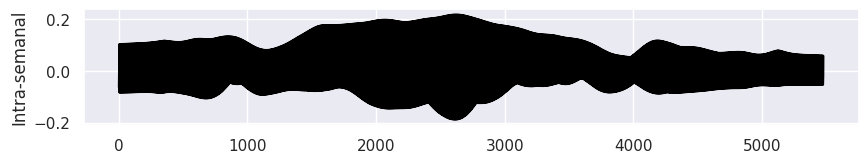

In [22]:
sns.lineplot(diario, alpha=1, color = 'black').set(xlabel=None)

[Text(0.5, 0, '')]

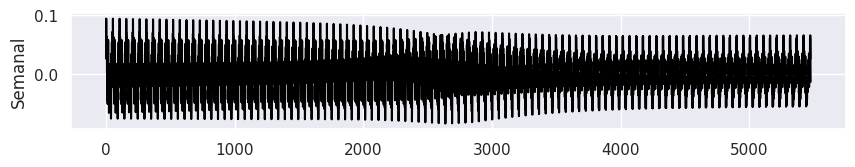

In [23]:
sns.lineplot(semanal, alpha=1, color = 'black').set(xlabel=None)

[Text(0.5, 0, '')]

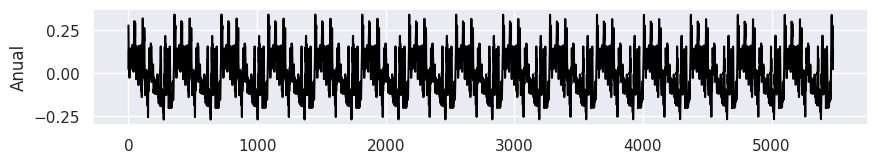

In [24]:
sns.lineplot(anual, alpha=1, color = 'black').set(xlabel=None)

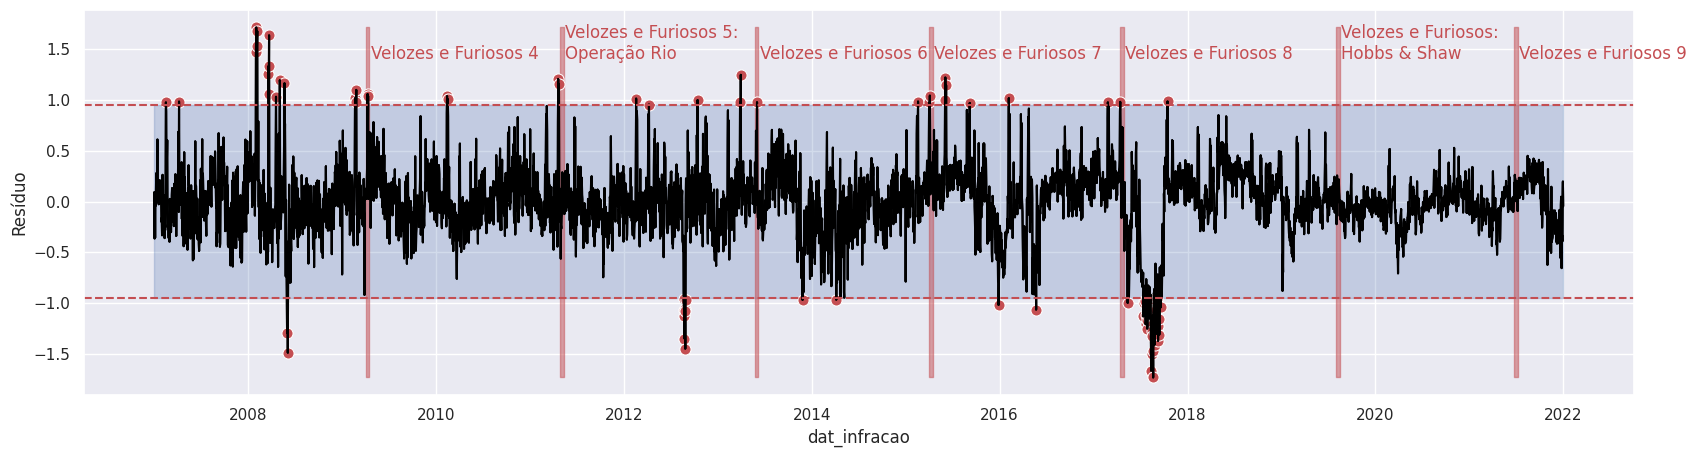

In [25]:
import matplotlib.pyplot as plt 

sns.set(rc={'figure.figsize':(20,5)})
filmes = {
    'Velozes e Furiosos 4': '2009-04-03', 
    'Velozes e Furiosos 5:\nOperação Rio': '2011-04-29', 
    'Velozes e Furiosos 6': '2013-05-24', 
    'Velozes e Furiosos 7': '2015-04-02', 
    'Velozes e Furiosos 8': '2017-04-13', 
    'Velozes e Furiosos:\nHobbs & Shaw' : '2019-08-01',
    'Velozes e Furiosos 9' : '2021-06-24'
    }

x = data
y = residuo

lower = results['Resíduo'].describe().loc['mean'] - 3 * results['Resíduo'].describe().loc['std']
upper = results['Resíduo'].describe().loc['mean'] + 3 * results['Resíduo'].describe().loc['std']
results_outliers = results.loc[(results['Resíduo'] <= lower) | (results['Resíduo'] >= upper)]

#outliers = result_window.loc[result_window['dat_infracao'].isin(results_outliers.dat_infracao)]

x_outliers = results_outliers['dat_infracao']
y_outliers = results_outliers['Resíduo']

fig = sns.lineplot(x=x_outliers, y=y_outliers,marker='o', linestyle='', dashes=False, alpha=1, markersize = 8, color='r')
sns.lineplot(x = x, y = y, color='black', ax=fig)
plt.plot(x,y,color='black')
#plt.xticks(range(2008,2022))
plt.fill_between(
    [pd.Timestamp(data.min()), pd.Timestamp(data.max())], 
    lower, 
    upper, 
    color='b', 
    alpha=0.25
    )
plt.axhline(
    lower, 
    color='r',
    linestyle='dashed')
plt.axhline(
    upper, 
    color='r',
    linestyle='dashed',
    alpha=1)

#plt.text(x=pd.Timestamp('2021-06-01'), y=lower-0.2, s='-3 desvios', color='r')
#plt.text(x=pd.Timestamp('2021-06-01'), y=upper+0.1, s='+3 desvios', color='r')

for filme, lanc in filmes.items():
#    plt.axvline(pd.Timestamp(lanc), color='r')
    plt.text(pd.Timestamp(lanc) + pd.DateOffset(days=20),1.4,s=filme, rotation=0, color='r')
    plt.fill_between(
        [pd.Timestamp(lanc), pd.Timestamp(lanc) + pd.DateOffset(days=14)],
        residuo.min(),
        residuo.max(),
        color='r',
        alpha=0.50,
        )


plt.show()

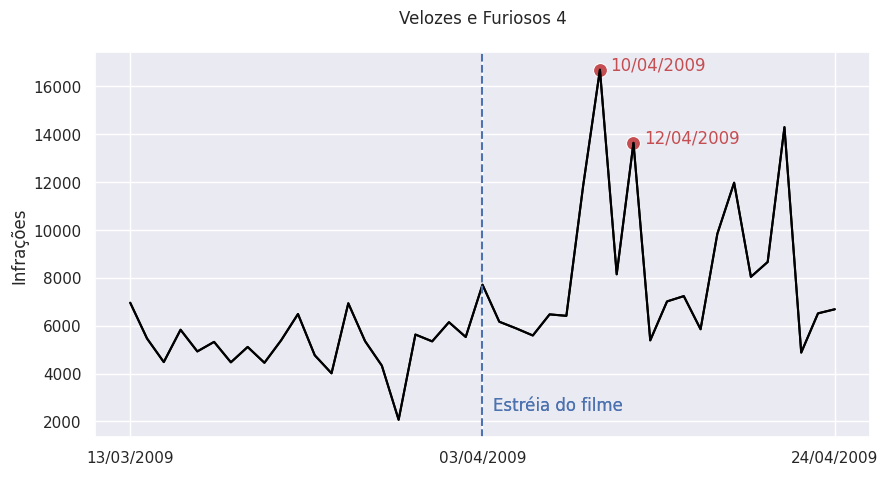

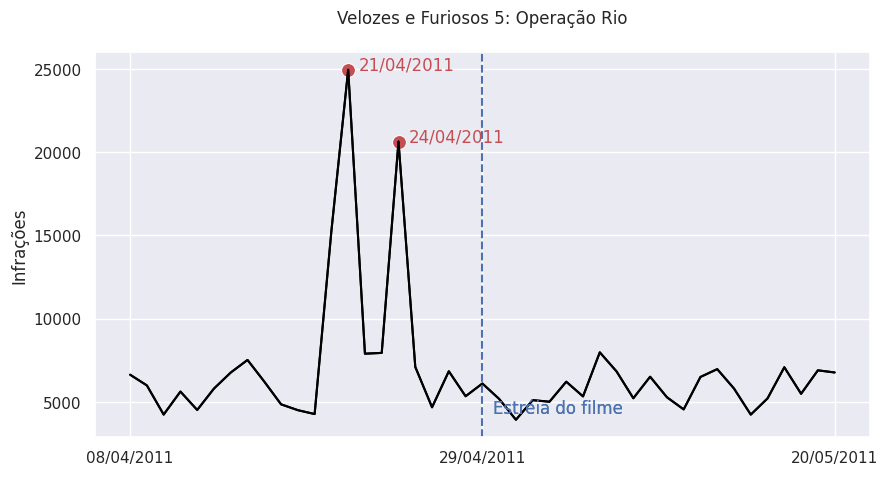

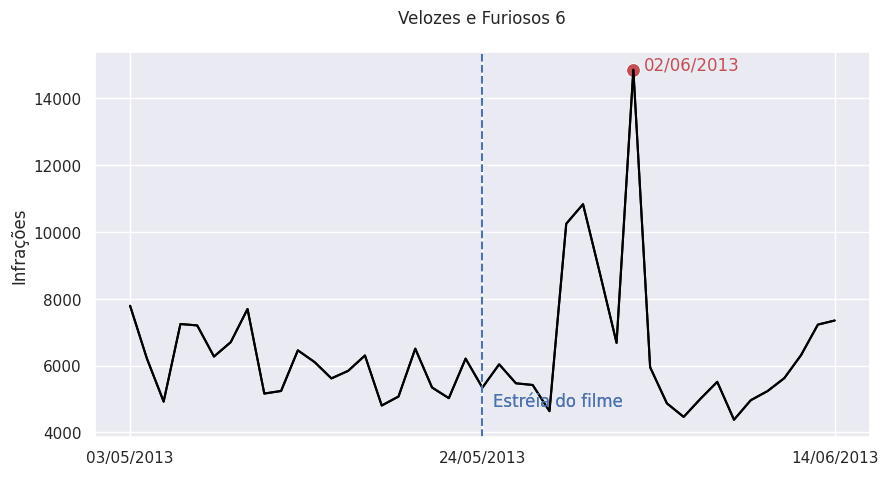

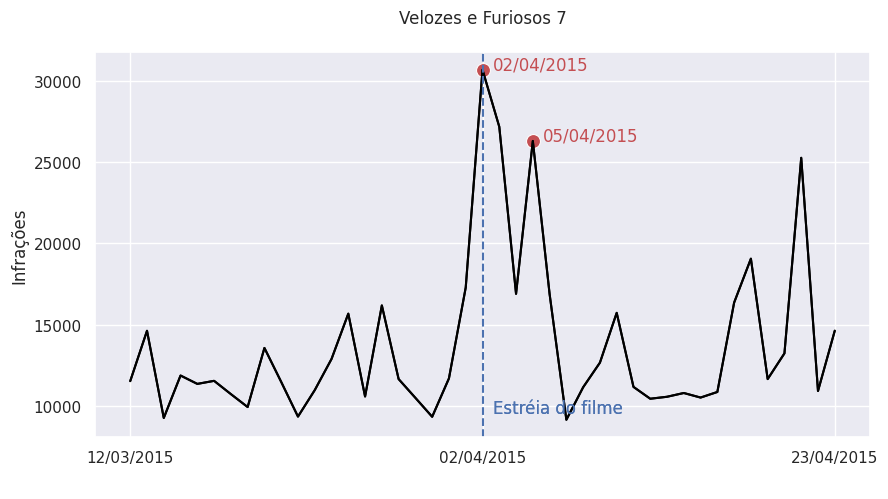

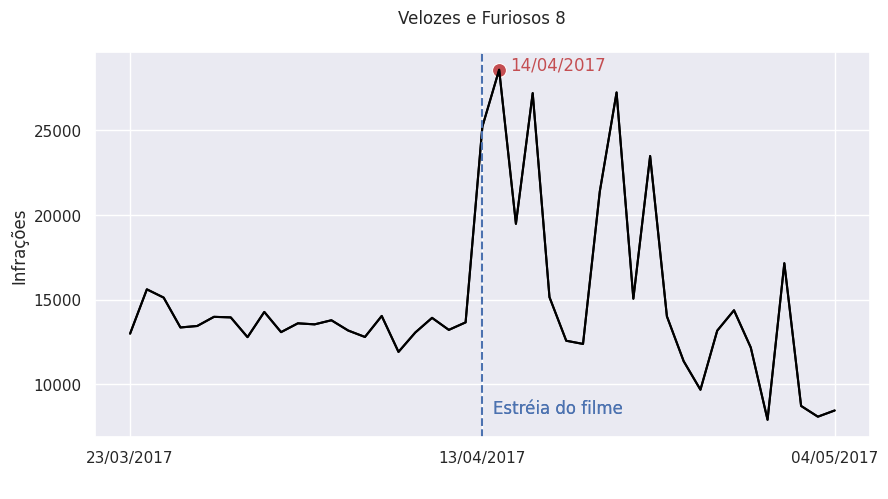

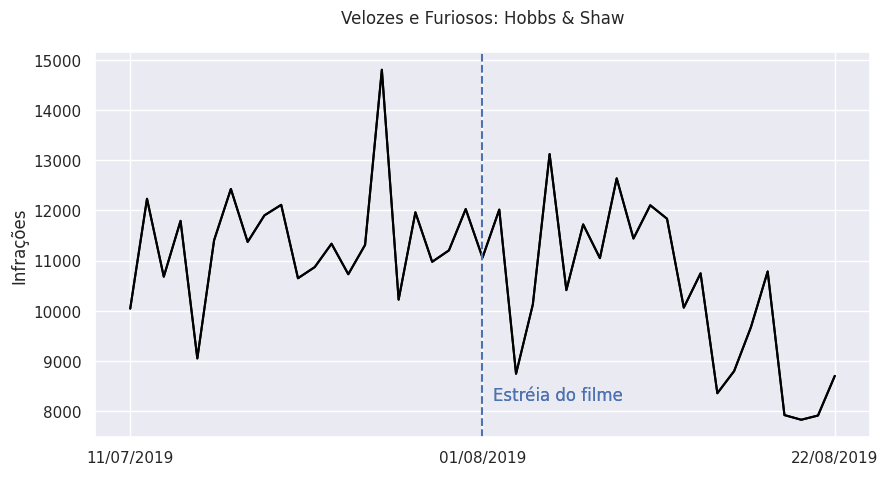

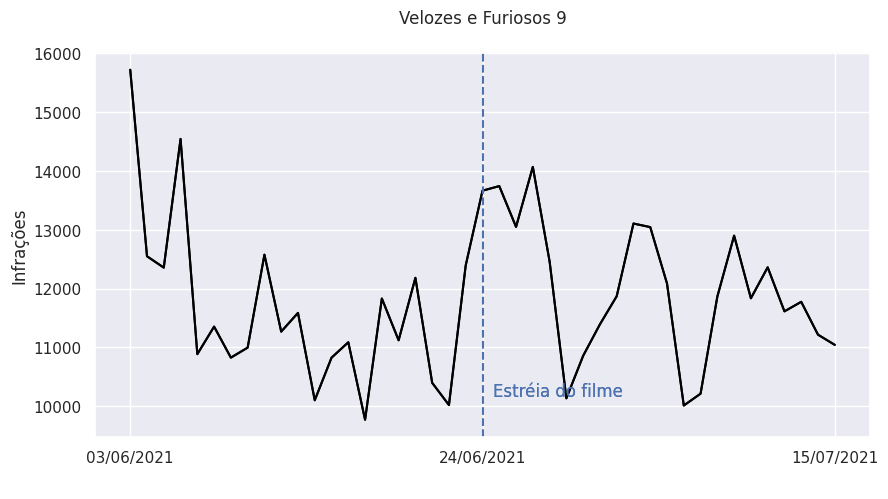

In [26]:
sns.set(rc={'figure.figsize':(10,5)})

filmes = {
    'Velozes e Furiosos 4': '2009-04-03', 
    'Velozes e Furiosos 5: Operação Rio': '2011-04-29', 
    'Velozes e Furiosos 6': '2013-05-24', 
    'Velozes e Furiosos 7': '2015-04-02', 
    'Velozes e Furiosos 8': '2017-04-13', 
    'Velozes e Furiosos: Hobbs & Shaw' : '2019-08-01',
    'Velozes e Furiosos 9' : '2021-06-24'
    }



for filme, lanc in filmes.items():

    data222 = pd.Timestamp(lanc,)
    dt_inic = data222 - pd.DateOffset(days=21)
    dt_fina = data222 + pd.DateOffset(days=21)
    result_window = df_2.loc[df_2.dat_infracao.between(dt_inic, dt_fina)]
    x_window = result_window['dat_infracao']
    y_window = result_window['Infrações']
    
    outliers = result_window.loc[result_window['dat_infracao'].isin(results_outliers.dat_infracao)]
    x_outliers = outliers['dat_infracao']
    y_outliers = outliers['Infrações']

    fig = sns.lineplot(x=x_outliers, y=y_outliers,marker='o', linestyle='', dashes=False, alpha=1, markersize = 10, color='r')
    fig.set(title=filme+'\n', xlabel=' ')
    
    sns.lineplot(x = x_window, y = y_window, color='black', ax=fig)
    plt.plot(x_window,y_window,color='black')
    plt.axvline(data222, color='b',linestyle='dashed')
    plt.xticks([dt_inic, data222, dt_fina], [dt_inic.strftime('%d/%m/%Y'), data222.strftime('%d/%m/%Y'), dt_fina.strftime('%d/%m/%Y')])
    plt.text(data222+ pd.DateOffset(hours=15),y_window.min()+400,s='Estréia do filme', rotation=0, color='b')
    plt.text(data222+ pd.DateOffset(hours=15),y_window.min()+400,s='Estréia do filme', rotation=0, color='b')
    
    for i in outliers.iloc:
        dd = i[0]
        infs = i[1]
        ddd = dd.strftime('%d/%m/%Y')
        plt.text(dd+ pd.DateOffset(hours=15),infs,s=ddd, rotation=0, color='r')


    
    
    plt.show()

(-0.2, 1.1)

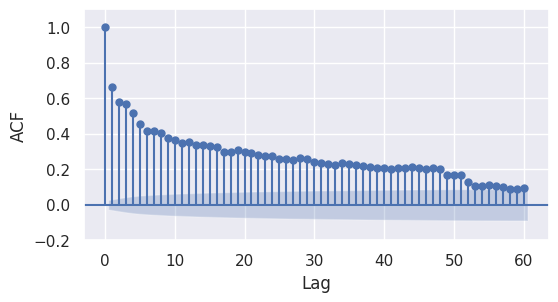

In [27]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

sns.set(rc={'figure.figsize':(6,3)})

filmes = {
    'Fast 4': '2009-04-03', 
    'Fast 5': '2011-04-29', 
    'Fast 6': '2013-05-24', 
    'Fast 7': '2015-04-02', 
    'Fast 8': '2017-04-13', 
    'Fast 9': '2021-06-24'
    }

plot_acf(res.resid, lags=60)

#acf_ = acf(residuo, nlags=2000)

plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('')
plt.ylim([-0.2, 1.1])

(-0.1, 1.1)

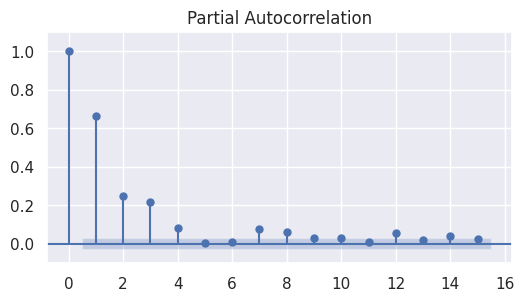

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(res.resid, lags = 15, method = "ols")
plt.ylim([-0.1, 1.1])

In [29]:
from scipy.stats import moment

print(moment(res.resid, moment=1))



print(moment(res.resid, moment=2))

print('pearson')
print(moment(res.resid, moment=3))

print()

print(moment(res.resid, moment=4))
print('curtose')

print()


0.0
0.09997141663914072
pearson
-0.009699274749816786

0.060958936354776345
curtose



#### Plotline (ggplot)

In [30]:
'''

import plotnine
from plotnine import ggplot, aes

filmes = {
    'Fast 4': '2009-04-03', 
    'Fast 5': '2011-04-29', 
    'Fast 6': '2013-05-24', 
    'Fast 7': '2015-04-02', 
    'Fast 8': '2017-04-13', 
    'Fast 9': '2021-06-24'
    }

filme = list(filmes.keys())
ano = list(filmes.values())

plotnine.options.figure_size = (15,5)


ggpl_line = ggplot(data=results, mapping=aes(x='dat_infracao', y='Resíduo'))
lineplot = (ggpl_line + 
plotnine.geom_line(color='black') + 
plotnine.labs(title='Resíduos')
# + plotnine.annotate('text', x=pd.Timestamp(ano[0]), y=4235, label=filme[0], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[1]), y=4235, label=filme[1], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[2]), y=4235, label=filme[2], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[3]), y=4235, label=filme[3], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[4]), y=4235, label=filme[4], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[5]), y=4235, label=filme[5], color='red')
).draw()

residuo_ = pd.DataFrame()
residuo_['Resíduo'] = (residuo - residuo.describe().mean() )/ residuo.describe().std()
residuo_.describe()

ggpl_hist = ggplot(residuo_, mapping=aes(x='Resíduo'))

histplot = (ggpl_hist 
            + plotnine.geom_histogram(fill='pink') 
            + plotnine.geom_density(alpha = 0.25)
            ).draw()



ggpl_line = ggplot(data=resuacf_lts, mapping=aes(x='dat_infracao', y='Resíduo'))
lineplot = (ggpl_line + 
plotnine.geom_line(color='black') + 
plotnine.labs(title='Resíduos')
# + plotnine.annotate('text', x=pd.Timestamp(ano[0]), y=4235, label=filme[0], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[1]), y=4235, label=filme[1], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[2]), y=4235, label=filme[2], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[3]), y=4235, label=filme[3], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[4]), y=4235, label=filme[4], color='red') +
#plotnine.annotate('text', x=pd.Timestamp(ano[5]), y=4235, label=filme[5], color='red')
).draw()
'''

pass